In [1]:
# Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from math import ceil
import datetime
import matplotlib.font_manager as fm
import matplotlib as mpl
import re


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#Modeling
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler



plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
os.getcwd()

'D:\\kaggle\\predict_future_sales\\competitive-data-science-predict-future-sales'

# Data Description
* You are provided with daily historical sales data.
* The task is to forecast the total amount of products sold in every shop for the test set.
* Note that the list of shops and products slightly changes every month.
* Creating a robust model that can handle such situations is part of the challenge.

# File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

# Load Data & Columns description
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [2]:
%%time
train=pd.read_csv("sales_train.csv",encoding='utf-8')
test=pd.read_csv("test.csv",encoding='utf-8')
items=pd.read_csv("items.csv",encoding='utf-8')
item_cats=pd.read_csv("item_categories.csv",encoding='utf-8')
shops=pd.read_csv("shops.csv",encoding='utf-8')

#date 열 datetime 으로 변경
train['date']=pd.to_datetime(train.date, format='%d.%m.%Y')

Wall time: 1.94 s


In [3]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.00


In [4]:
test.head(1)

,ID,shop_id,item_id
0,0,5,5037


In [5]:
items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [6]:
item_cats.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


In [7]:
shops.head(1)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


# Name correction function
* codes referenced: https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
* .partition('str') : split strings by reference of 'str'
* re.sub('exp','non exp changing reference', data)
* .replace('a', 'b') : replace a with b 
* .strip() : strip blanks 

In [8]:
## name corretion func 
# 1) lower caplitalize string 
# 2) split by '[' and '('
# 3) drop special strings( select eng/num/russian only )
# 4) replace double space to space
# 5) drop balnks 

def name_correction(x):
    x = x.lower() # lower capitalize string
    x = x.partition('[')[0] 
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) #just select eng/num/russian
    x = x.replace('  ', ' ') #replace '  ' to ' '
    x = x.strip() # delete blanks
    return x

# 1. items 
### item_name : drop special str only 

In [9]:
items['item_name'] = items['item_name'].apply(name_correction)
items.loc[:2,['item_id','item_name']]

,item_id,item_name
0,0,во власти наваждения
1,1,abbyy finereader 12 professional edition full
2,2,в лучах славы


# 2. item_cats
### item_category_name : split main / sub category

In [10]:
item_cats['item_category_main'] = item_cats['item_category_name'].str.split(' - ').apply(lambda x : x[0])
item_cats['item_category_sub'] = item_cats['item_category_name'].str.split(' - ').apply(lambda x : x[-1])
item_cats.loc[:2,['item_category_name','item_category_main','item_category_sub']]

,item_category_name,item_category_main,item_category_sub
0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,Аксессуары,PS2
2,Аксессуары - PS3,Аксессуары,PS3


# 3. shops : split shop_city / shop_type 
#### 몇가지 문제점 발생
#### 1) name_correction 진행 시, H.Новгород에 대한 파싱이 잘못됨 
* н.новгород(city) / трц(type) / фантастика(etc) [정상]
* н(city) /новгород(type) / трц фантастика(etc) [비정상]
#### ->  H.Новгород -> Нижний_Новгород 이므로 H만 따로 빠져나온거 풀네임 다시 돌려놓고 진행

In [11]:
shops['shop_city'] = shops['shop_name'].apply(name_correction).str.split(' ').apply(lambda x: x[0])
shops['shop_city'].value_counts()

москва          13
якутск           4
ростовнадону     3
тюмень           3
воронеж          3
новосибирск      2
жуковский        2
н                2
самара           2
спб              2
казань           2
уфа              2
красноярск       2
мытищи           1
омск             1
сургут           1
волжский         1
томск            1
интернет         1
калуга           1
ярославль        1
выездная         1
балашиха         1
коломна          1
вологда          1
курск            1
химки            1
адыгея           1
цифровой         1
сергиев          1
чехов            1
Name: shop_city, dtype: int64

In [12]:
shops.loc[shops.shop_city=='н',['shop_name','shop_city']].head(3)

,shop_name,shop_city
34,"Н.Новгород ТРЦ ""РИО""",н
35,"Н.Новгород ТРЦ ""Фантастика""",н


In [13]:
shops.loc[shops.shop_city=='н',['shop_city']] = 'нижний_новгород'

In [14]:
shops.loc[shops.shop_city=='н']

,shop_name,shop_id,shop_city


#### 2) shop_name 이 city+type+etc로 구성되지 않고 city+etc이거나 다른 경우 존재, 이 경우 type가 없으므로 'others'로 퉁 치기

In [15]:
shops['shop_type'] = shops['shop_name'].apply(name_correction).str.split(' ').apply(lambda x: x[1] if (len(x)>1) else 'other')
shops['shop_type'].value_counts()

тц              27
трц              9
тк               5
трк              5
орджоникидзе     2
магазин          2
новгород         2
ул               2
склад            1
other            1
мтрц             1
торговля         1
посад            1
распродажа       1
Name: shop_type, dtype: int64

In [16]:
shop_type_other = ((shops['shop_type']=='орджоникидзе')|
                  (shops['shop_type']=='ул')|
                  (shops['shop_type']=='распродажа')|
                  (shops['shop_type']=='торговля')|
                  (shops['shop_type']=='магазин'))
shops.loc[shop_type_other]

,shop_name,shop_id,shop_city,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,якутск,орджоникидзе
9,Выездная Торговля,9,выездная,торговля
10,Жуковский ул. Чкалова 39м?,10,жуковский,ул
11,Жуковский ул. Чкалова 39м²,11,жуковский,ул
12,Интернет-магазин ЧС,12,интернет,магазин
20,"Москва ""Распродажа""",20,москва,распродажа
22,Москва Магазин С21,22,москва,магазин
57,"Якутск Орджоникидзе, 56",57,якутск,орджоникидзе


In [17]:
shops.loc[shop_type_other,'shop_type'] = 'other'

In [18]:
shops.loc[(shops['shop_type']=='новгород')|
           (shops['shop_type']=='мтрц'),['shop_name','shop_city','shop_type']]

,shop_name,shop_city,shop_type
21,"Москва МТРЦ ""Афи Молл""",москва,мтрц
34,"Н.Новгород ТРЦ ""РИО""",нижний_новгород,новгород
35,"Н.Новгород ТРЦ ""Фантастика""",нижний_новгород,новгород


In [19]:
shops.loc[(shops['shop_type']=='новгород')|
           (shops['shop_type']=='мтрц'),'shop_type'] = 'трц' 

In [20]:
shops.loc[(shops['shop_type']=='новгород')|
           (shops['shop_type']=='мтрц'),:]

,shop_name,shop_id,shop_city,shop_type


In [21]:
shops.loc[(shops['shop_type']=='посад'), :]

,shop_name,shop_id,shop_city,shop_type
46,"Сергиев Посад ТЦ ""7Я""",46,сергиев,посад


In [22]:
shops.loc[(shops['shop_type']=='посад'), 'shop_type'] = 'тц'
shops.loc[shops['shop_name']=='Сергиев Посад ТЦ "7Я"']

,shop_name,shop_id,shop_city,shop_type
46,"Сергиев Посад ТЦ ""7Я""",46,сергиев,тц


In [23]:
shops['shop_type'].value_counts()

тц       28
трц      12
other     9
трк       5
тк        5
склад     1
Name: shop_type, dtype: int64

# Merge Data
* train 파일 기반으로 흩어져 있는 데이터 병합
* revenue 열 생성 : item_price * item_cnt_day 

In [24]:
#merge data
train=pd.merge(train,items,how='left',on='item_id')
train=pd.merge(train,item_cats,how='left',on='item_category_id')
train=pd.merge(train,shops,how='left',on='shop_id')

#make columns 'revenue'
train['revenue'] = train['item_price'] * train['item_cnt_day']
train.head(1)

train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,item_category_main,item_category_sub,shop_name,shop_city,shop_type,revenue
0,2013-01-02,0,59,22154,999.00,1.00,явление 2012,37,Кино - Blu-Ray,Кино,Blu-Ray,"Ярославль ТЦ ""Альтаир""",ярославль,тц,999.00


### columns index arrange

In [25]:
train=train.reindex(columns=[
        'date', 'date_block_num',  
        'item_id', 'item_name', 'item_price','item_cnt_day',          
        'item_category_id','item_category_name','item_category_main', 'item_category_sub', 
        'shop_id','shop_name','shop_city', 'shop_type',
        'revenue'])
train.head(1)

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue
0,2013-01-02,0,22154,явление 2012,999.00,1.00,37,Кино - Blu-Ray,Кино,Blu-Ray,59,"Ярославль ТЦ ""Альтаир""",ярославль,тц,999.00


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 15 columns):
date                  datetime64[ns]
date_block_num        int64
item_id               int64
item_name             object
item_price            float64
item_cnt_day          float64
item_category_id      int64
item_category_name    object
item_category_main    object
item_category_sub     object
shop_id               int64
shop_name             object
shop_city             object
shop_type             object
revenue               float64
dtypes: datetime64[ns](1), float64(3), int64(4), object(7)
memory usage: 358.4+ MB


In [27]:
train.isna().sum()

date                  0
date_block_num        0
item_id               0
item_name             0
item_price            0
item_cnt_day          0
item_category_id      0
item_category_name    0
item_category_main    0
item_category_sub     0
shop_id               0
shop_name             0
shop_city             0
shop_type             0
revenue               0
dtype: int64

# EDA(by Columns)

## 1. [ Date ] 
* 연 기준: 거래횟수 감소추세 (2013 > 2014 > 2015)
* 월 기준: 12,1,2,3 월 거래횟수 많음
* 일 기준: 거래횟수 비슷비슷

In [28]:
print('[ date ]')
print('- Unique : {}'.format(train.date.nunique()))
print('- Min : {}'.format(train.date.min()))
print('- Max : {}'.format(train.date.max()))

[ date ]
- Unique : 1034
- Min : 2013-01-01 00:00:00
- Max : 2015-10-31 00:00:00


In [29]:
train['year_month']=train['date'].apply(lambda x: x.strftime('%Y-%m'))
train['year']=train.date.dt.year
train['month']=train.date.dt.month
train['day']=train.date.dt.day
train.head(3)

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue,year_month,year,month,day
0,2013-01-02,0,22154,явление 2012,999.00,1.00,37,Кино - Blu-Ray,Кино,Blu-Ray,59,"Ярославль ТЦ ""Альтаир""",ярославль,тц,999.00,2013-01,2013,1,2
1,2013-01-03,0,2552,deep purple the house of blue light lp,899.00,1.00,58,Музыка - Винил,Музыка,Винил,25,"Москва ТРК ""Атриум""",москва,трк,899.00,2013-01,2013,1,3
2,2013-01-05,0,2552,deep purple the house of blue light lp,899.00,-1.00,58,Музыка - Винил,Музыка,Винил,25,"Москва ТРК ""Атриум""",москва,трк,-899.00,2013-01,2013,1,5


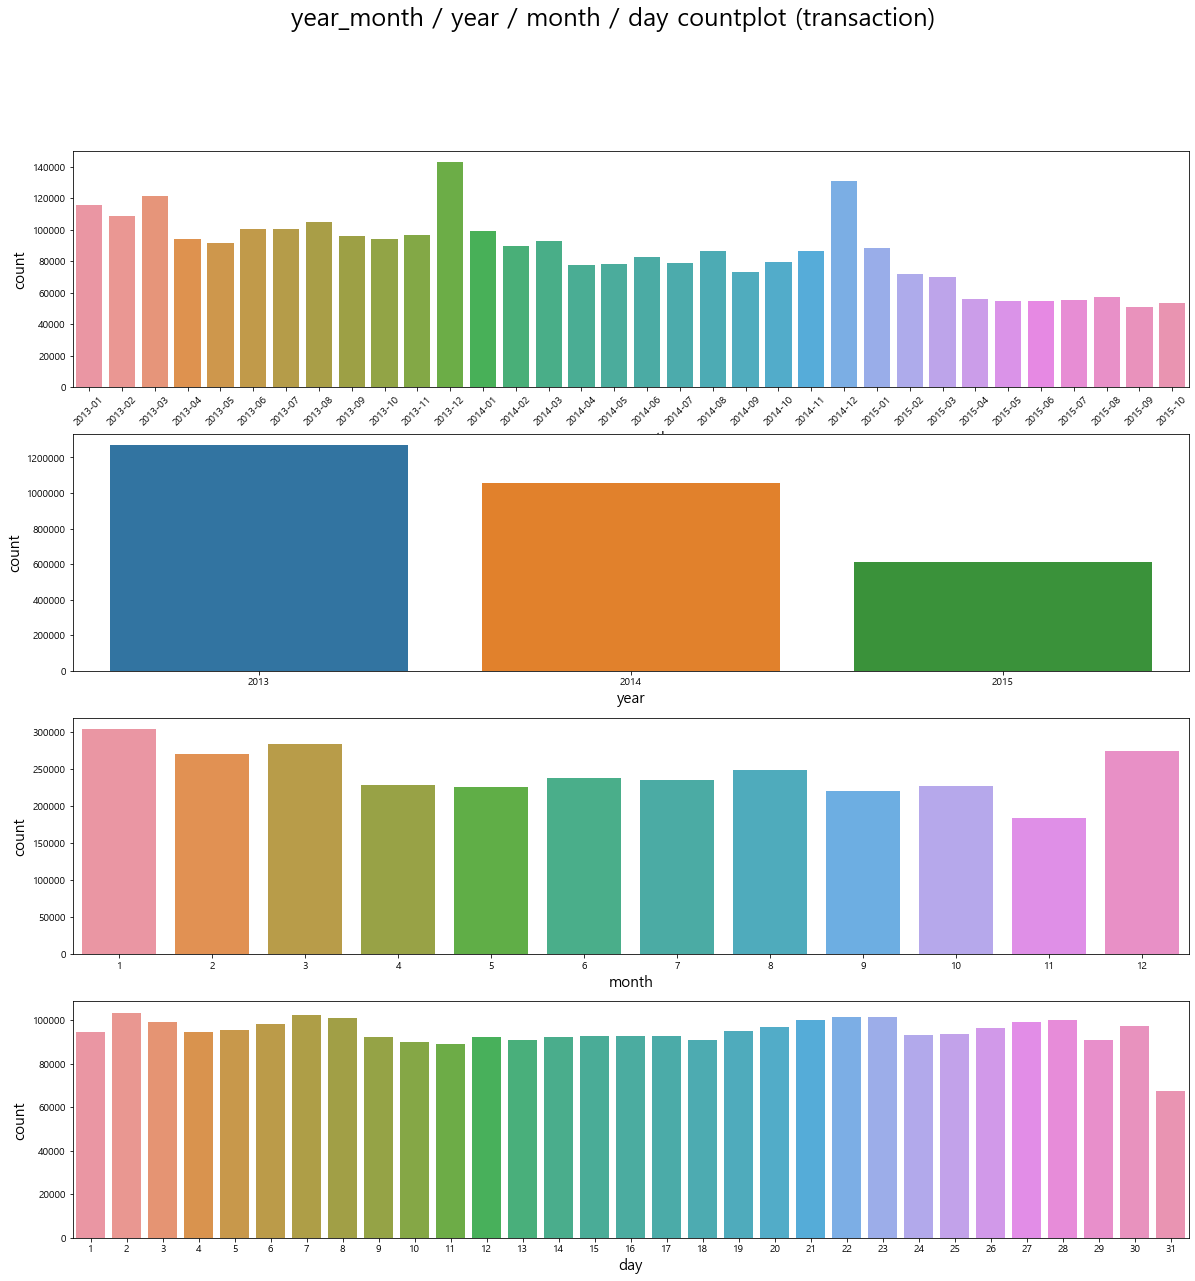

In [30]:
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
fig.suptitle('year_month / year / month / day countplot (transaction)', fontsize= 25)
g = sns.countplot(train.year_month, ax=ax[0], order=sorted(train.year_month.unique()))
g.set_xticklabels(g.get_xticklabels(), rotation=45)
sns.countplot(train.year, ax=ax[1])
sns.countplot(train.month, ax=ax[2])
sns.countplot(train.day, ax=ax[3])

# 2. [ date_block_num ]
* 첫 날을 기준으로 1달 간격으로 나눈거 (2013.01 => 0 / 2013.02 =>1 ..... / 2015.12 =>33)
* date_block_num 변화에 따른 거래량과, 거래액의 변화가 비슷한 양상을 보임

In [31]:
print('[ date_block_num ]'.format(train.date_block_num.nunique()))
print('- Unique : {}'.format(train.date_block_num.nunique()))
print('- Min: {}'.format(train.date_block_num.min()))
print('- Max: {}'.format(train.date_block_num.max()))

[ date_block_num ]
- Unique : 34
- Min: 0
- Max: 33


In [32]:
date_block_num_df=\
    train.groupby('date_block_num')['item_price','item_cnt_day']\
    .agg({'item_price':['sum','mean'],
          'item_cnt_day':['sum']}).reset_index()
date_block_num_df.columns=['date_block_num','item_price_sum','item_price_mean','item_cnt_sum']
date_block_num_df[:10]

,date_block_num,item_price_sum,item_price_mean,item_cnt_sum
0,0,82211873.88,710.62,131479.00
1,1,75580186.84,695.87,128090.00
2,2,84298312.38,694.69,147142.00
3,3,61512822.96,653.63,107190.00
4,4,57274131.97,624.18,106970.00
5,5,63343614.55,630.89,125381.00
6,6,62196805.57,618.58,116966.00
7,7,65438166.22,624.58,125291.00
8,8,72701570.39,756.23,133332.00
9,9,73914970.76,784.64,127541.00


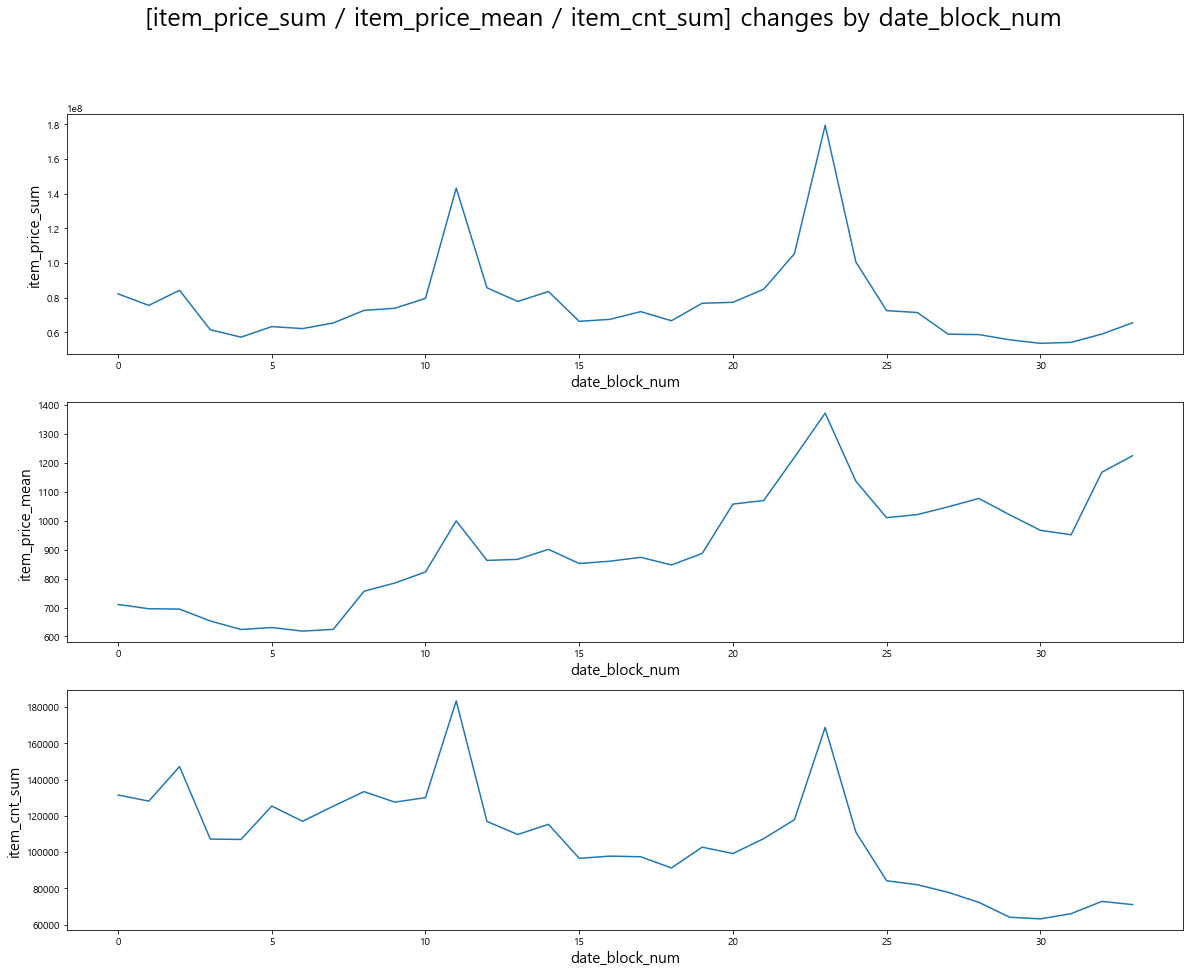

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
fig.suptitle('[item_price_sum / item_price_mean / item_cnt_sum] changes by date_block_num ', fontsize= 25)

sns.lineplot(x='date_block_num',
             y='item_price_sum',
             data=date_block_num_df,
             ax=ax[0])

sns.lineplot(x='date_block_num',
             y='item_price_mean',
             data=date_block_num_df,
             ax=ax[1])

sns.lineplot(x='date_block_num',
             y='item_cnt_sum',
             data=date_block_num_df,
             ax=ax[2])

# 3. [ item ] ( id, name, price ,cnt_day)
* 최다 매출 item : sony playstation 4
* 최다 판매량 item : фирменный пакет майка 1с интерес белый	

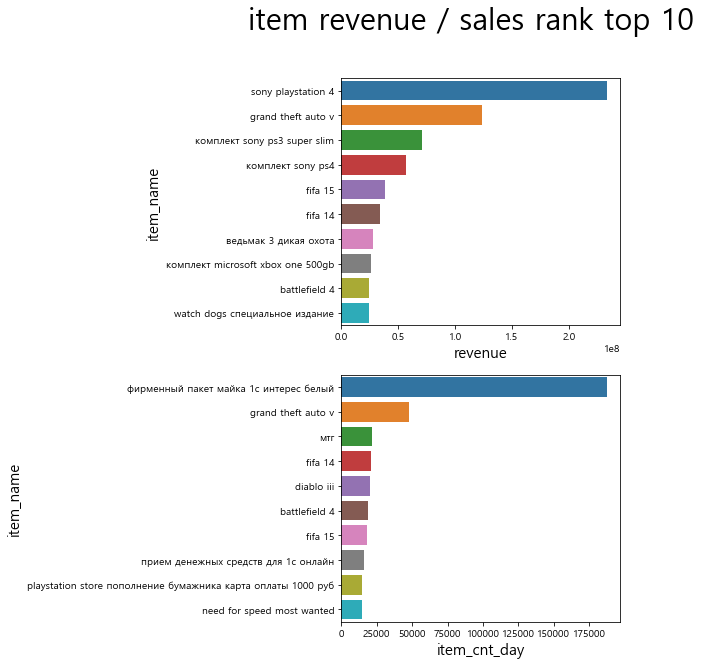

In [34]:
item_revenue_rank10=train.groupby('item_name')['item_name','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
item_cnt_rank10=train.groupby('item_name')['item_name','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]

fig, ax = plt.subplots(2,1, figsize=(5,10))
plt.suptitle('item revenue / sales rank top 10 ', fontsize=30)
sns.barplot(data=item_revenue_rank10,
            x='revenue', y='item_name', ax=ax[0])
sns.barplot(data=item_cnt_rank10,
            x='item_cnt_day', y='item_name', ax=ax[1])

# 4. [ item_category ] ( id, name, main, sub )
* 최다 판매량 category : Кино - DVD
* 최다 판매량 category_main : Кино
* 최다 판매량 category_sub : DVD
<br><br>
* 최다 판매액 category : Игры - PS3
* 최다 판매액 category_main : Игры
* 최다 판매액 category_sub : PS4	

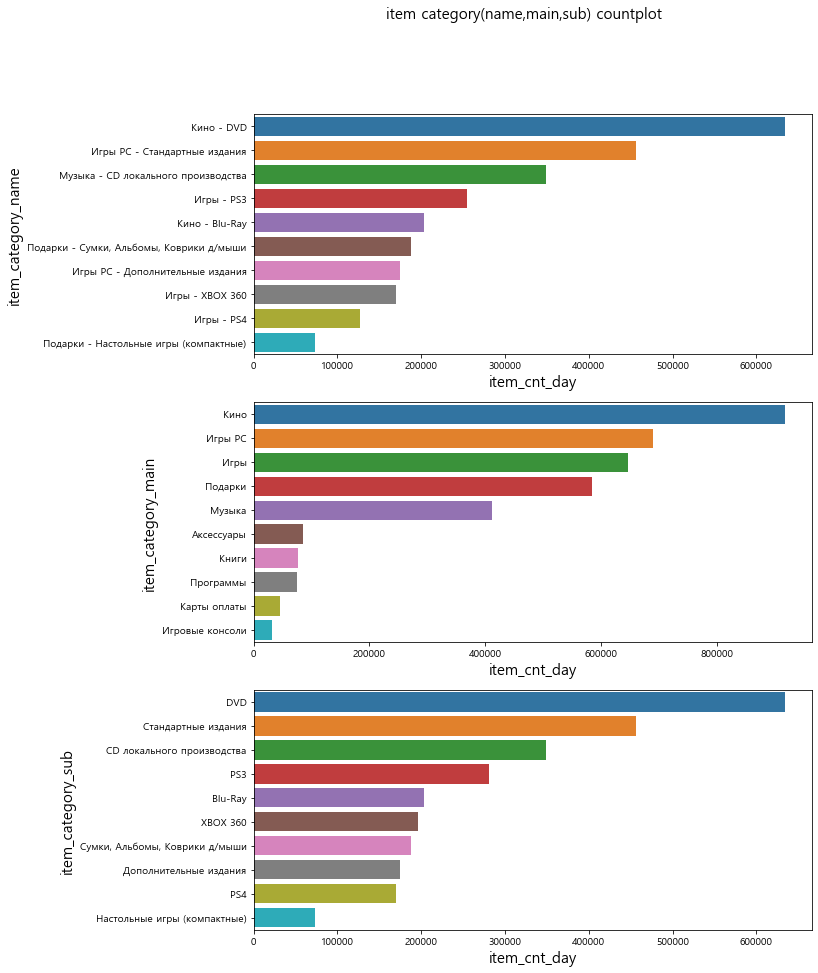

In [35]:
item_category_name10=train.groupby('item_category_name')['item_category_name','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]
item_category_main10=train.groupby('item_category_main')['item_category_main','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]
item_category_sub10=train.groupby('item_category_sub')['item_category_sub','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]


fig, ax = plt.subplots(3,1, figsize=(10,15))
plt.suptitle('item category(name,main,sub) countplot', fontsize=15)
sns.barplot(data=item_category_name10,
            x='item_cnt_day', y='item_category_name', ax=ax[0])
sns.barplot(data=item_category_main10,
            x='item_cnt_day', y='item_category_main', ax=ax[1])
sns.barplot(data=item_category_sub10,
            x='item_cnt_day', y='item_category_sub', ax=ax[2])

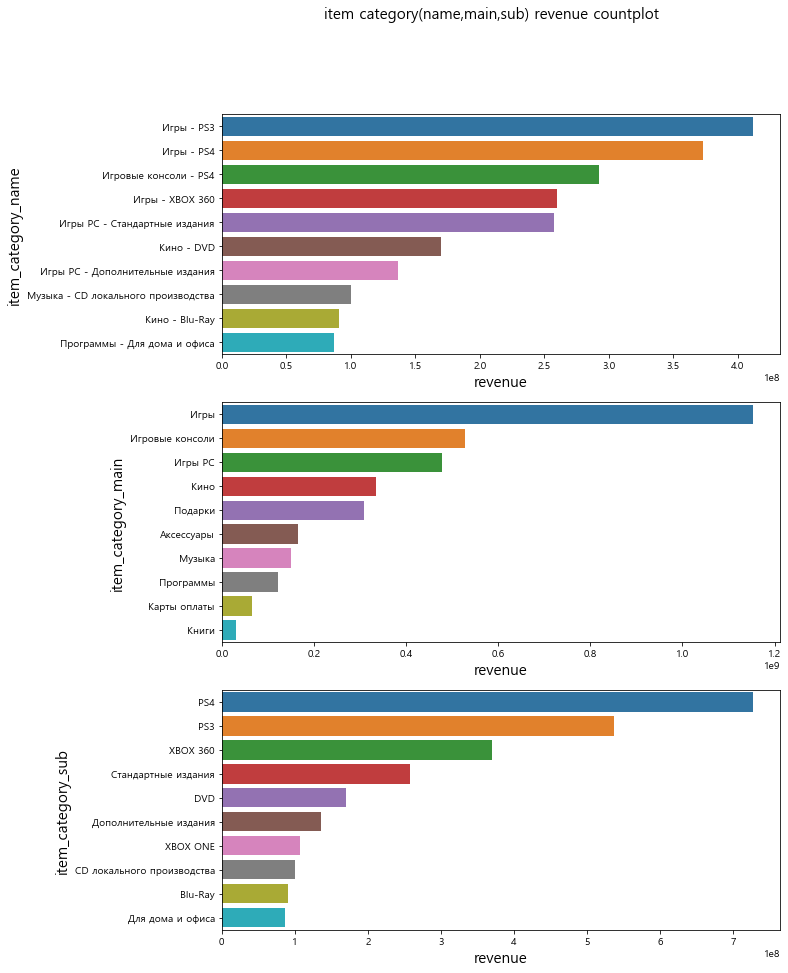

In [36]:
item_category_name10_rev=train.groupby('item_category_name')['item_category_name','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
item_category_main10_rev=train.groupby('item_category_main')['item_category_main','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
item_category_sub10_rev=train.groupby('item_category_sub')['item_category_sub','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]


fig, ax = plt.subplots(3,1, figsize=(10,15))
plt.suptitle('item category(name,main,sub) revenue countplot', fontsize=15)
sns.barplot(data=item_category_name10_rev,
            x='revenue', y='item_category_name', ax=ax[0])
sns.barplot(data=item_category_main10_rev,
            x='revenue', y='item_category_main', ax=ax[1])
sns.barplot(data=item_category_sub10_rev,
            x='revenue', y='item_category_sub', ax=ax[2])

# 5. [ shop ] ( id, name, city, type )
* 최다 판매량 shop : Москва ТЦ "Семеновский"
* 최다 판매량 city : москва
* 최다 판매량 type : тц
<br><br>
* 최다 판매액 shop : Москва ТЦ "Семеновский"
* 최다 판매액 city : москва
* 최다 판매액 type : тц

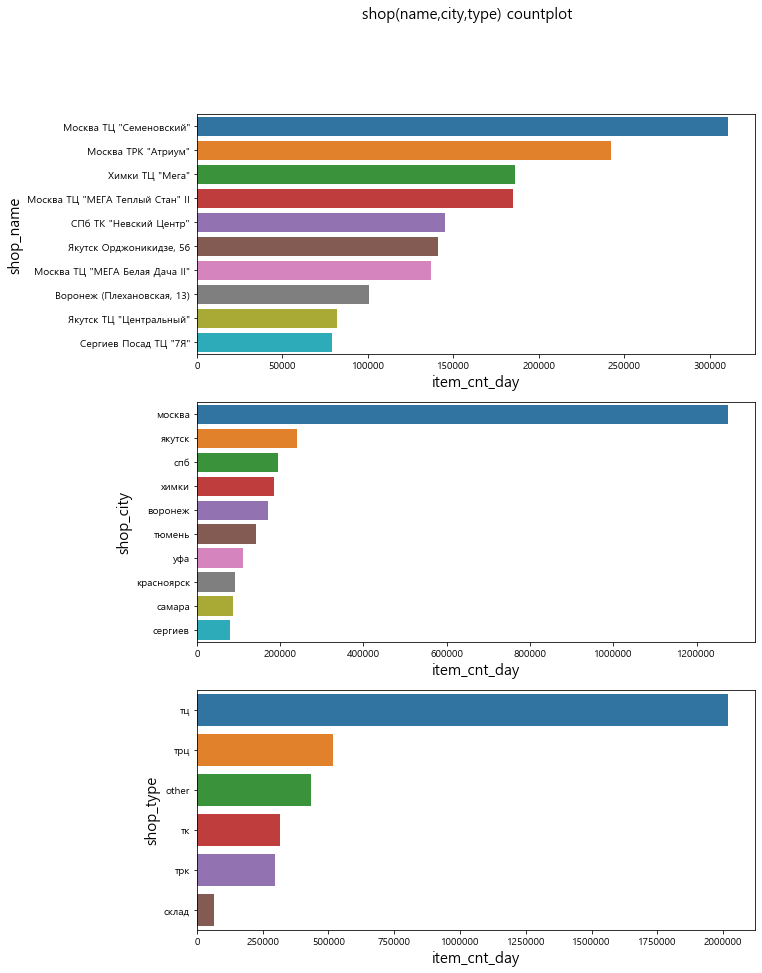

In [37]:
shop_name10=train.groupby('shop_name')['shop_name','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]
shop_city10=train.groupby('shop_city')['shop_city','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]
shop_type10=train.groupby('shop_type')['shop_type','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]


fig, ax = plt.subplots(3,1, figsize=(10,15))
plt.suptitle('shop(name,city,type) countplot', fontsize=15)
sns.barplot(data=shop_name10,
            x='item_cnt_day', y='shop_name', ax=ax[0])
sns.barplot(data=shop_city10,
            x='item_cnt_day', y='shop_city', ax=ax[1])
sns.barplot(data=shop_type10,
            x='item_cnt_day', y='shop_type', ax=ax[2])

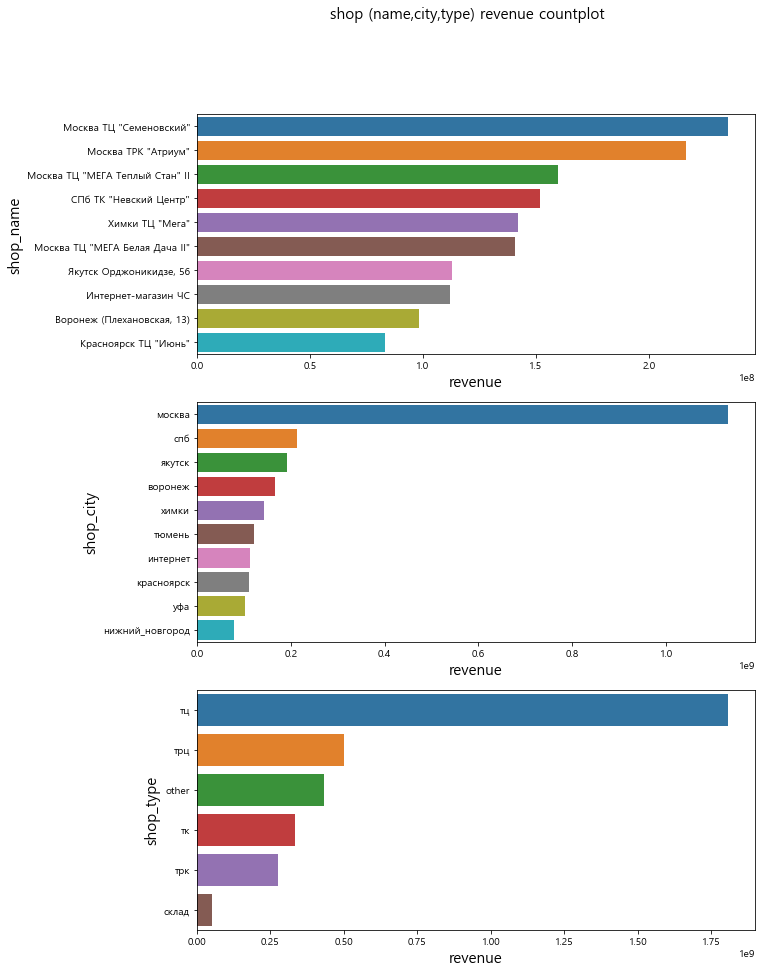

In [38]:
shop_name10_rev=train.groupby('shop_name')['shop_name','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
shop_city10_rev=train.groupby('shop_city')['shop_city','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
shop_type10_rev=train.groupby('shop_type')['shop_type','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]


fig, ax = plt.subplots(3,1, figsize=(10,15))
plt.suptitle('shop (name,city,type) revenue countplot', fontsize=15)
sns.barplot(data=shop_name10_rev,
            x='revenue', y='shop_name', ax=ax[0])
sns.barplot(data=shop_city10_rev,
            x='revenue', y='shop_city', ax=ax[1])
sns.barplot(data=shop_type10_rev,
            x='revenue', y='shop_type', ax=ax[2])

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 19 columns):
date                  datetime64[ns]
date_block_num        int64
item_id               int64
item_name             object
item_price            float64
item_cnt_day          float64
item_category_id      int64
item_category_name    object
item_category_main    object
item_category_sub     object
shop_id               int64
shop_name             object
shop_city             object
shop_type             object
revenue               float64
year_month            object
year                  int64
month                 int64
day                   int64
dtypes: datetime64[ns](1), float64(3), int64(7), object(8)
memory usage: 528.0+ MB


# 6. [ revenue & item_cnt_day variation] by date_block_num

In [40]:
date_block_num_group=train.groupby('date_block_num')['revenue','item_cnt_day']\
                                                    .agg({'revenue':['sum','mean','std'],
                                                          'item_cnt_day':['sum','mean','std']}).reset_index()

date_block_num_group.columns=['date_block_num',
                              'revenue_sum','revenue_mean','revenue_std',
                              'item_cnt_sum','item_cnt_mean','item_cnt_std']

date_block_num_group.head(3)

,date_block_num,revenue_sum,revenue_mean,revenue_std,item_cnt_sum,item_cnt_mean,item_cnt_std
0,0,91947091.13,794.77,1454.28,131479.00,1.14,0.68
1,1,90665707.37,834.76,1579.87,128090.00,1.18,0.88
2,2,104932687.15,864.73,1740.42,147142.00,1.21,1.11


In [41]:
date_block_num_group_unpivot = date_block_num_group.melt(id_vars=['date_block_num'], var_name='stat_type', value_name='value')
date_block_num_group_unpivot

,date_block_num,stat_type,value
0,0,revenue_sum,91947091.13
1,1,revenue_sum,90665707.37
2,2,revenue_sum,104932687.15
3,3,revenue_sum,69154285.55
4,4,revenue_sum,65065312.46
...,...,...,...
199,29,item_cnt_std,1.18
200,30,item_cnt_std,1.02
201,31,item_cnt_std,1.14
202,32,item_cnt_std,6.13


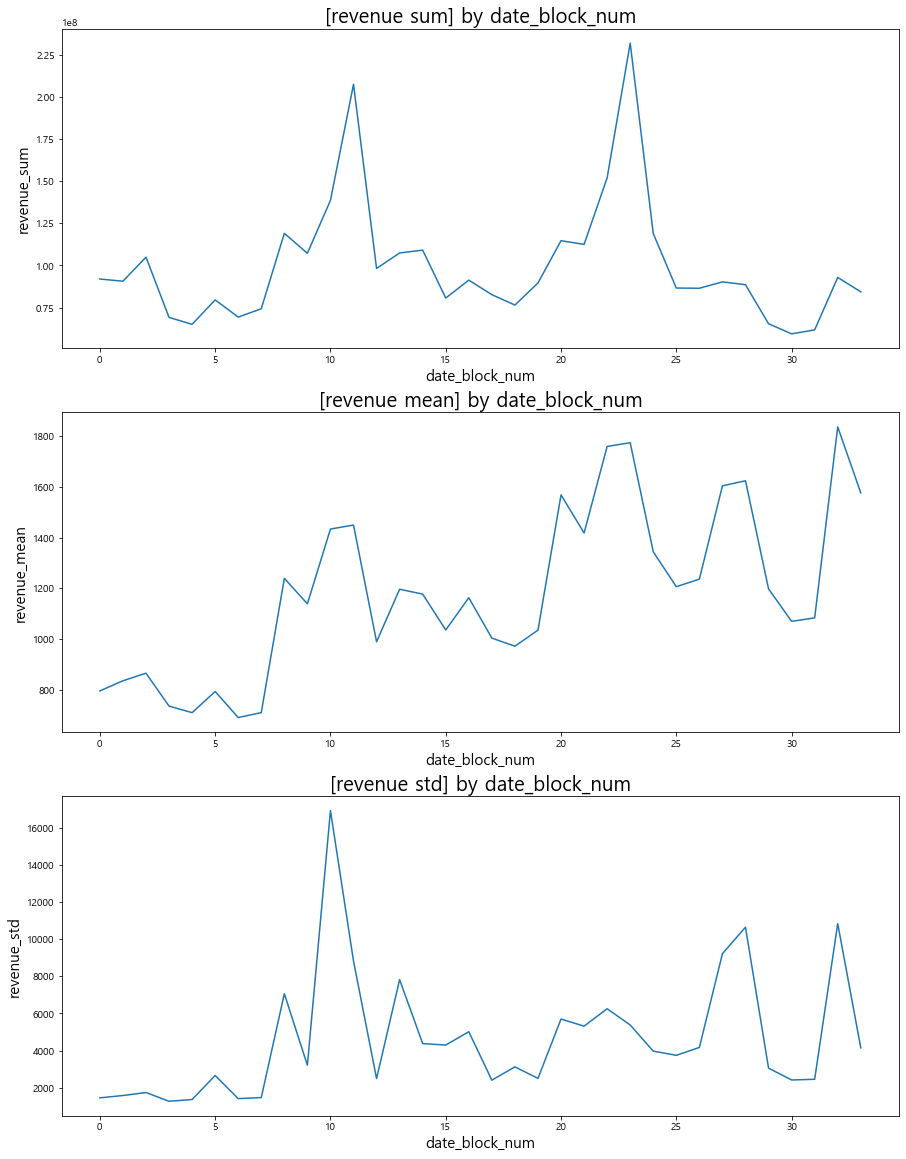

In [42]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(15,20))
#plt.suptitle('revenue lineplot by date_block_num', fontsize=25)

ax0.set_title('[revenue sum] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='revenue_sum',ax=ax0)

ax1.set_title('[revenue mean] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='revenue_mean',ax=ax1)

ax2.set_title('[revenue std] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='revenue_std',ax=ax2)

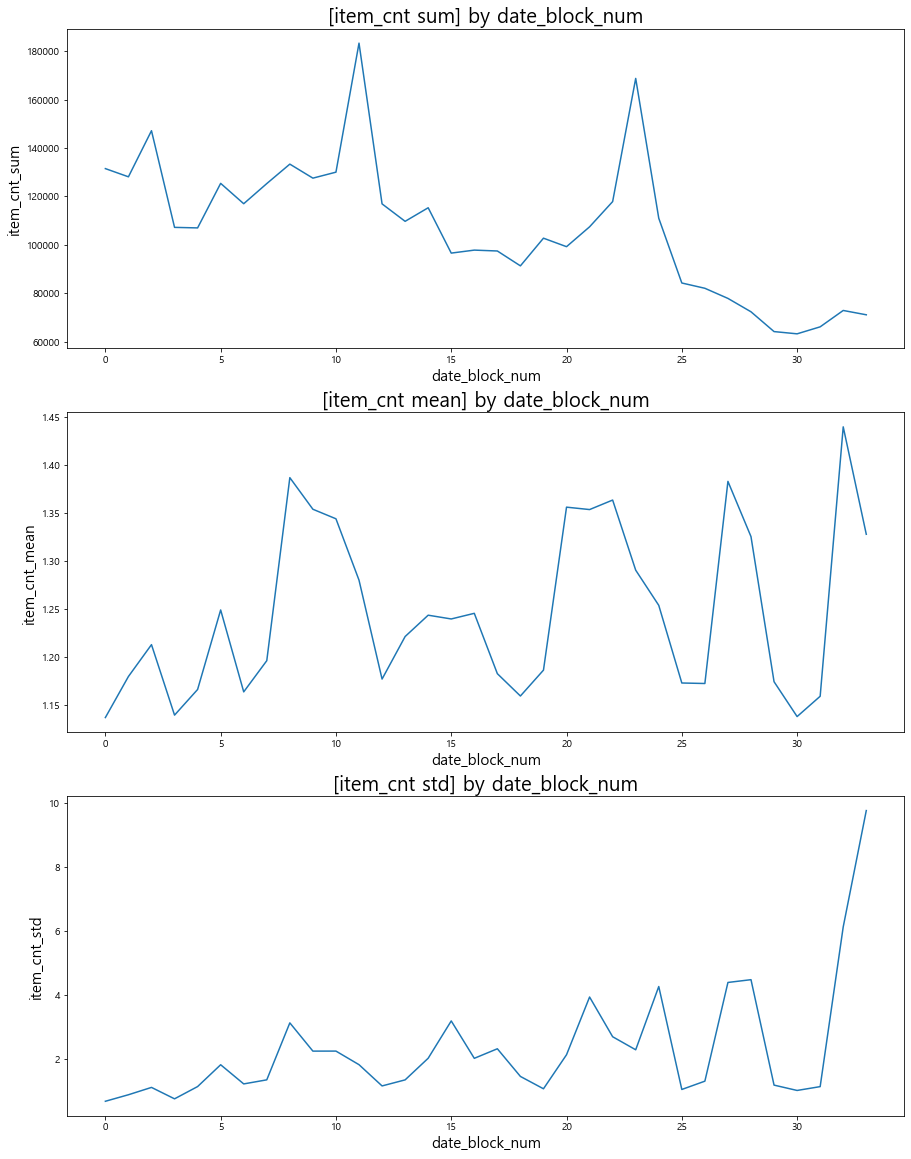

In [43]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(15,20))
#plt.suptitle('item_cnt lineplot by date_block_num', fontsize=25)

ax0.set_title('[item_cnt sum] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='item_cnt_sum',ax=ax0)

ax1.set_title('[item_cnt mean] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='item_cnt_mean',ax=ax1)

ax2.set_title('[item_cnt std] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='item_cnt_std',ax=ax2)

# item_price 와 item_cnt_day 간 상관관계 확인

In [44]:
print('# item_price / item_cnt_day corr : {}'.format(train['item_price'].corr(train['item_cnt_day'])))
print('# 값    0.01 /  상관관계 없다고 판단됨')

# item_price / item_cnt_day corr : 0.011196625252355607
# 값    0.01 /  상관관계 없다고 판단됨


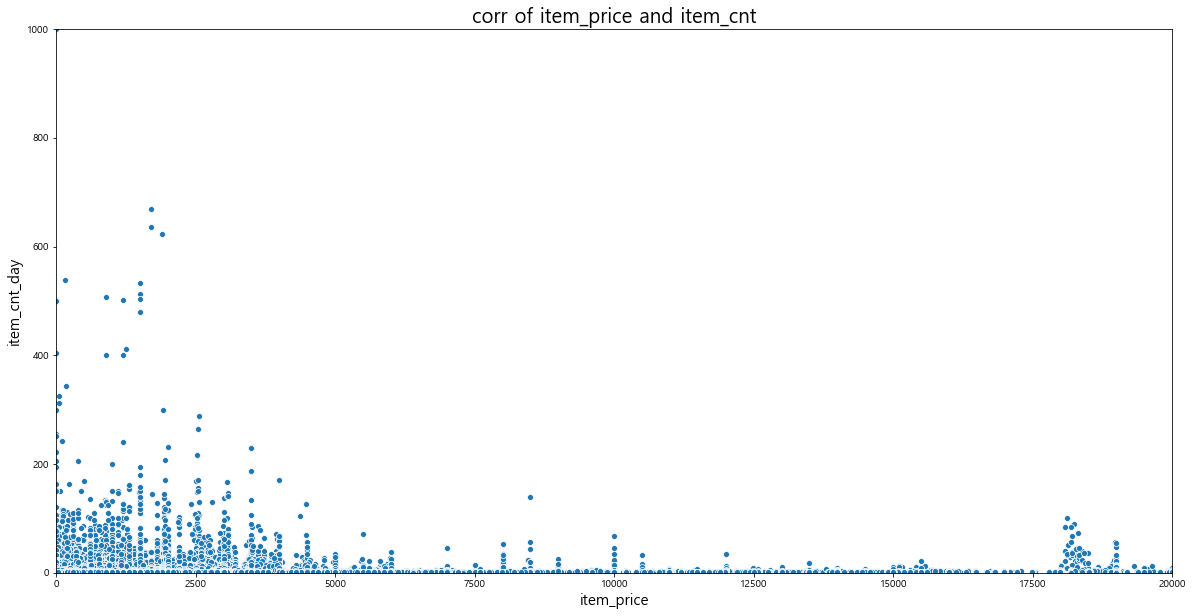

In [45]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('corr of item_price and item_cnt')
ax=sns.scatterplot(data=train, x='item_price', y='item_cnt_day')
ax.set_xlim(0, 20000)
ax.set_ylim(0, 1000)
plt.show()

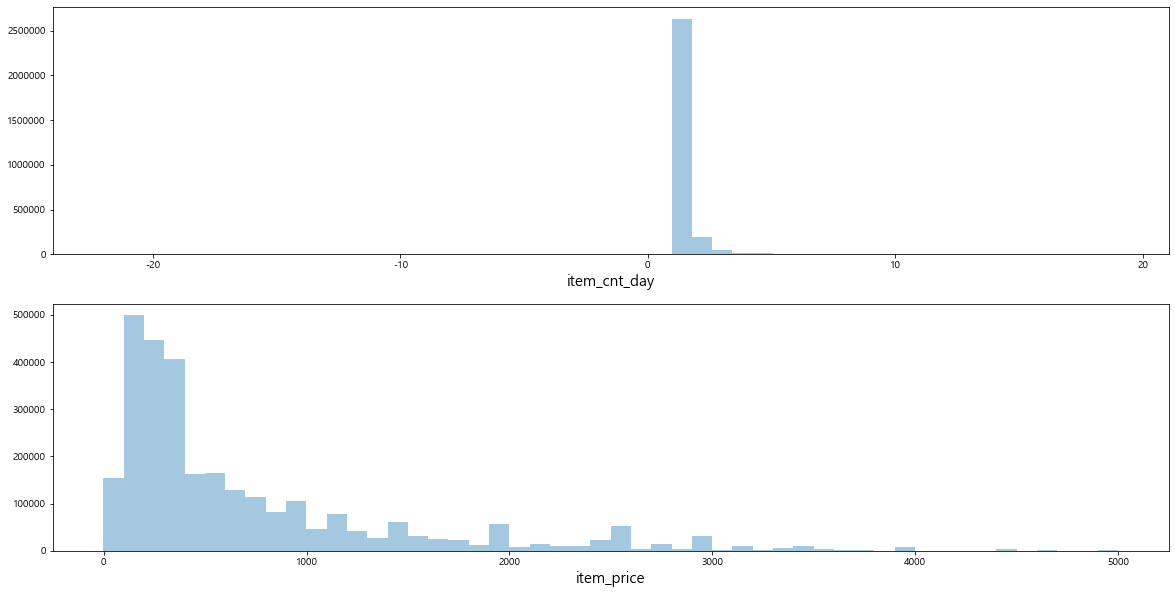

In [46]:
fig, ax = plt.subplots(2,1,figsize = (20,10))
sns.distplot(train['item_cnt_day'].loc[train['item_cnt_day'] < 20], ax=ax[0], kde=False)
sns.distplot(train['item_price'].loc[train['item_price'] < 5000], ax=ax[1], kde=False)

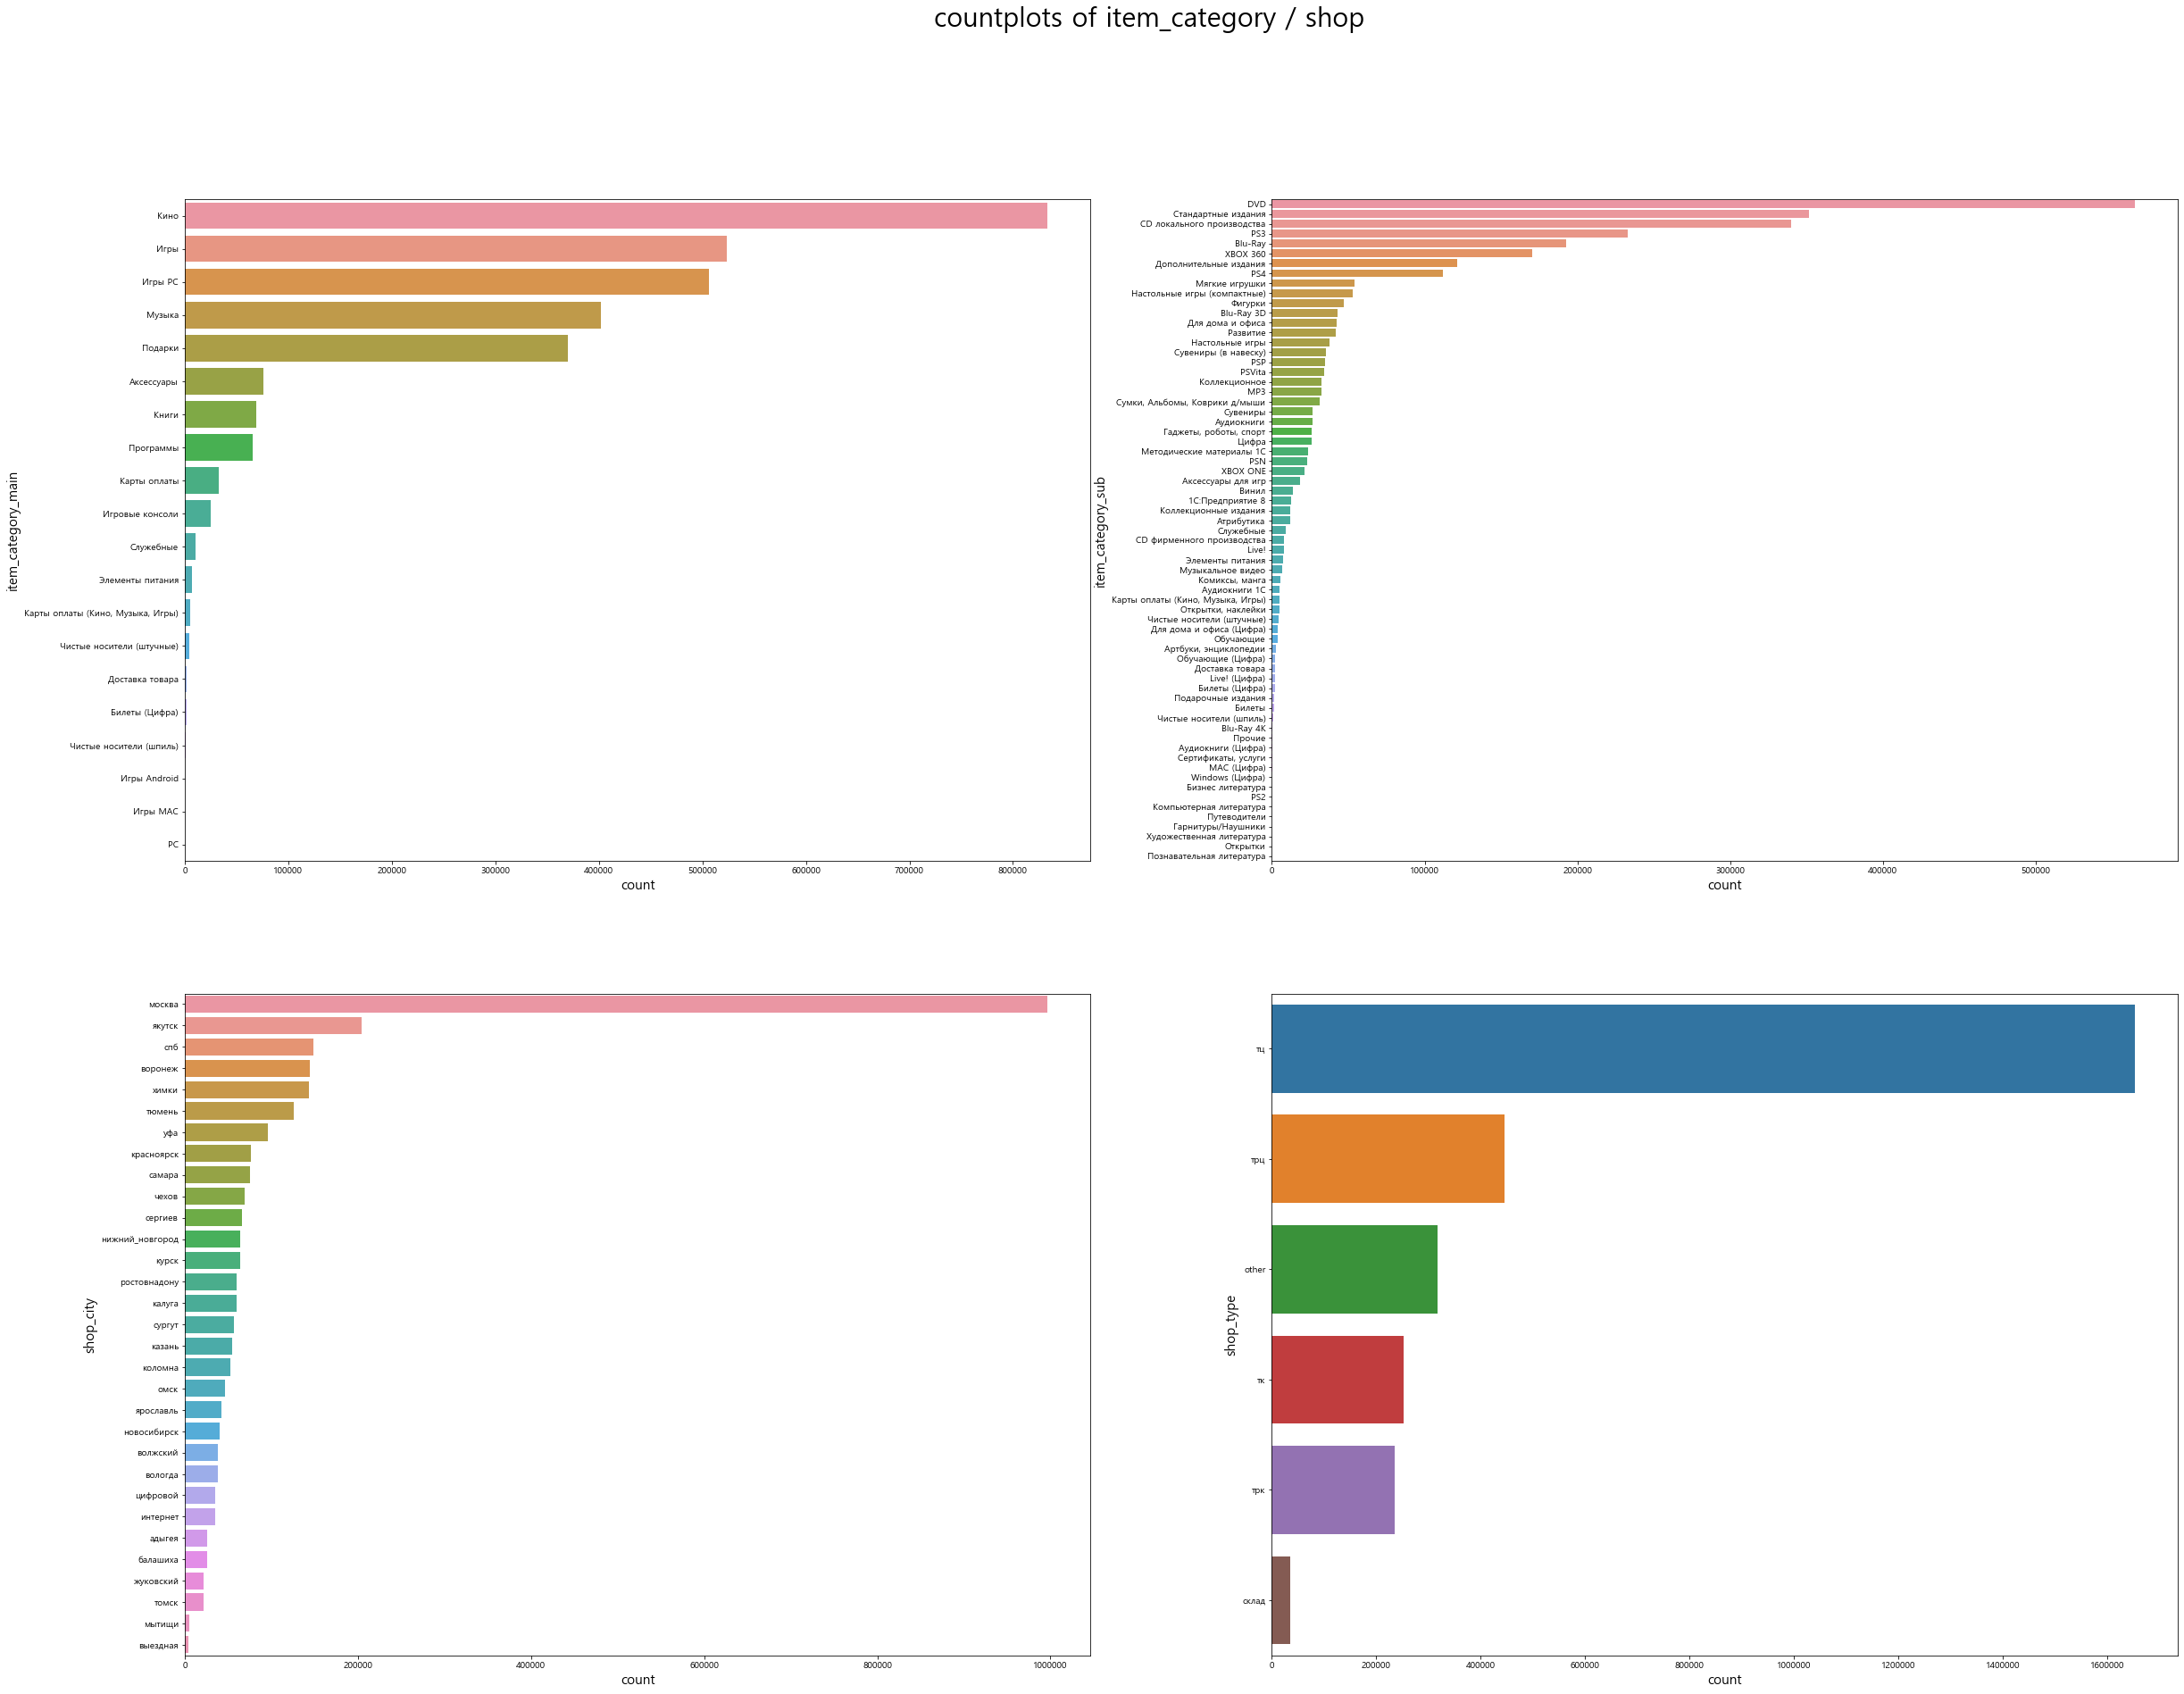

In [47]:
fig, ax = plt.subplots(2,2, figsize=(40,30))
plt.suptitle('countplots of item_category / shop',fontsize=30)
#plt.xticks(rotation=90)

sns.countplot(y=train['item_category_main'], ax=ax[0][0],
              order=train['item_category_main'].value_counts().index)

sns.countplot(y=train['item_category_sub'], ax=ax[0][1],
              order=train['item_category_sub'].value_counts().index)

sns.countplot(y=train['shop_city'], ax=ax[1][0],
              order=train['shop_city'].value_counts().index)

sns.countplot(y=train['shop_type'], ax=ax[1][1],
              order=train['shop_type'].value_counts().index)

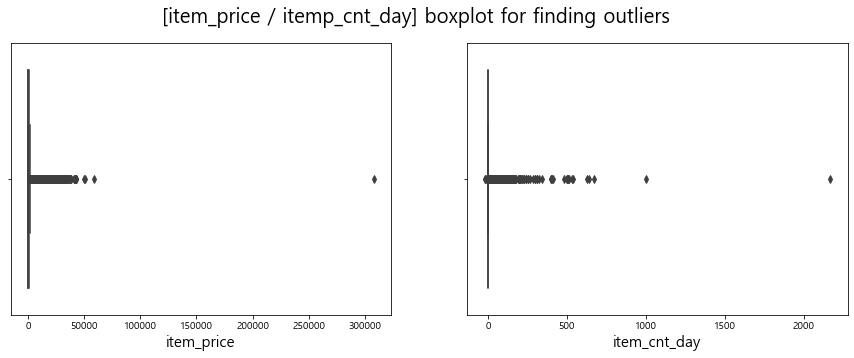

In [48]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.suptitle('[item_price / itemp_cnt_day] boxplot for finding outliers',fontsize=20)
#plt.xticks(rotation=90)
sns.boxplot(train['item_price'],  ax=ax[0]) #orient='v'
sns.boxplot(train['item_cnt_day'], ax=ax[1])

In [49]:
train.loc[train.item_cnt_day>2000]

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue,year_month,year,month,day
2909818,2015-10-28,33,11373,доставка до пункта выдачи,0.91,2169.00,9,Доставка товара,Доставка товара,Доставка товара,12,Интернет-магазин ЧС,интернет,other,1971.00,2015-10,2015,10,28


In [50]:
train.loc[train.item_price>300000]

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue,year_month,year,month,day
1163158,2013-12-13,11,6066,radmin 3 522 лиц,307980.00,1.00,75,Программы - Для дома и офиса,Программы,Для дома и офиса,12,Интернет-магазин ЧС,интернет,other,307980.00,2013-12,2013,12,13


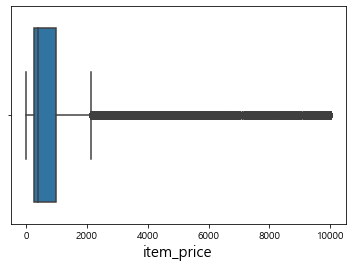

In [51]:
sns.boxplot(train['item_price'][train['item_price']<10000]) #orient='v'

In [52]:
len(train['item_price'][train['item_price']>2000])

266190

In [53]:
len(train['item_price'])

2935849

In [54]:
len(train['item_price'][train['item_price']>2000]) / len(train['item_price'])* 100

9.066883208230395

In [55]:
train['item_price'].nlargest(20)

1163158   307980.00
885138     59200.00
1488135    50999.00
2327159    49782.00
2885692    42990.00
2910156    42990.00
2917760    42990.00
2931380    42990.00
1006638    42000.00
2893100    41990.00
2910155    41990.00
2913267    41990.00
2927572    40991.00
2143903    40900.00
2885694    37991.00
2932637    37991.00
884848     36990.00
1394150    36990.00
1592289    36990.00
1656109    36990.00
Name: item_price, dtype: float64

In [56]:
train['item_price'].nsmallest(20)

484683   -1.00
579766    0.07
608763    0.07
611400    0.09
673155    0.09
531561    0.10
531564    0.10
531566    0.10
531567    0.10
531568    0.10
531569    0.10
531570    0.10
531571    0.10
531572    0.10
531573    0.10
531574    0.10
531575    0.10
531580    0.10
531581    0.10
531582    0.10
Name: item_price, dtype: float64

In [57]:
train['item_cnt_day'].nsmallest(20)

1057907   -22.00
1835454   -16.00
2048519    -9.00
59156      -6.00
940092     -6.00
59155      -5.00
93576      -5.00
2458733    -5.00
2619997    -5.00
222426     -4.00
1058703    -4.00
2568004    -4.00
59161      -3.00
369918     -3.00
836324     -3.00
1005832    -3.00
1058696    -3.00
1192939    -3.00
1330713    -3.00
1404269    -3.00
Name: item_cnt_day, dtype: float64

In [58]:
train['item_cnt_day'].nlargest(20)

2909818   2169.00
2326930   1000.00
2864235    669.00
2851091    637.00
2608040    624.00
2626181    539.00
2851073    533.00
2048518    512.00
2067669    508.00
2864260    504.00
1573253    502.00
1708207    501.00
2257299    500.00
2909401    500.00
2625847    480.00
2067677    412.00
1501160    405.00
1573252    401.00
2067667    401.00
2626133    343.00
Name: item_cnt_day, dtype: float64

In [59]:
train.drop(index=1163158, inplace=True)

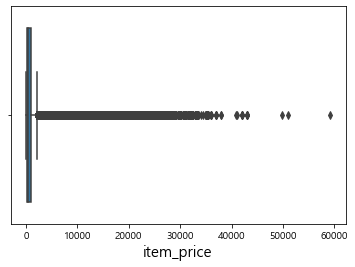

In [60]:
sns.boxplot(train['item_price'])

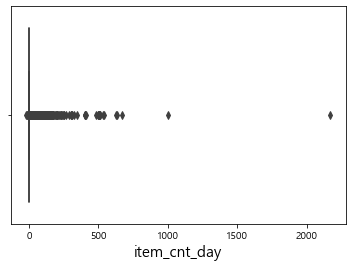

In [61]:
sns.boxplot(train['item_cnt_day'])

In [62]:
train.loc[train['item_cnt_day']==2169.0]

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue,year_month,year,month,day
2909818,2015-10-28,33,11373,доставка до пункта выдачи,0.91,2169.00,9,Доставка товара,Доставка товара,Доставка товара,12,Интернет-магазин ЧС,интернет,other,1971.00,2015-10,2015,10,28


In [63]:
test_item_ids=test['item_id'].unique()
test_shop_ids=test['shop_id'].unique()

lk_train=train.loc[train['item_id'].isin(test_item_ids)]
lk_train=lk_train.loc[lk_train['shop_id'].isin(test_shop_ids)]

print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935848
Data set size after leaking: 1224439


In [64]:
lk_train.head(3)

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue,year_month,year,month,day
0,2013-01-02,0,22154,явление 2012,999.00,1.00,37,Кино - Blu-Ray,Кино,Blu-Ray,59,"Ярославль ТЦ ""Альтаир""",ярославль,тц,999.00,2013-01,2013,1,2
10,2013-01-03,0,2574,del rey lana born to die the paradise edition 2cd,399.00,2.00,55,Музыка - CD локального производства,Музыка,CD локального производства,25,"Москва ТРК ""Атриум""",москва,трк,798.00,2013-01,2013,1,3
11,2013-01-05,0,2574,del rey lana born to die the paradise edition 2cd,399.00,1.00,55,Музыка - CD локального производства,Музыка,CD локального производства,25,"Москва ТРК ""Атриум""",москва,трк,399.00,2013-01,2013,1,5


In [65]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [66]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [67]:
train_monthly

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9.00,1.29,7
1,0,2,2,5643,4775.21,2387.61,0.00,0.00,2
2,0,2,5,5583,1188.30,594.15,2.00,1.00,2
3,0,2,6,7893,5970.00,1990.00,3.00,1.00,3
4,0,2,6,7894,1490.00,1490.00,1.00,1.00,1
...,...,...,...,...,...,...,...,...,...
600154,33,59,75,5383,4390.00,4390.00,1.00,1.00,1
600155,33,59,79,17717,8025.50,802.55,13.00,1.30,10
600156,33,59,83,22087,357.00,119.00,6.00,2.00,3
600157,33,59,83,22088,238.00,119.00,2.00,1.00,2


In [68]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
empty_df

,date_block_num,shop_id,item_id
0,0,2,5572
1,0,2,5643
2,0,2,5583
3,0,2,7893
4,0,2,7894
...,...,...,...
6734443,33,36,9103
6734444,33,36,9107
6734445,33,36,5704
6734446,33,36,12733


In [69]:
34*len(shop_ids)*len(item_ids)

6734448

In [70]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00
6734444,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00
6734445,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00
6734446,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00


In [71]:
temp_df=train.sort_values('date').groupby(['date_block_num','item_id','shop_id'])\
                                 ['item_price','item_cnt_day']\
                                 .agg({'item_price' : ['min','max','sum','mean'],
                                       'item_cnt_day' : ['min','max','sum','mean']}).reset_index(drop=True)
#temp_df.columns=['_'.join(col).strip() for col in temp_df.columns.values]
temp_df

item_price                         item_cnt_day               
               min     max     sum    mean          min  max  sum mean
0            28.00   28.00   28.00   28.00         1.00 1.00 1.00 1.00
1          1890.00 1890.00 1890.00 1890.00         1.00 1.00 1.00 1.00
2          2499.00 2499.00 2499.00 2499.00         1.00 1.00 1.00 1.00
3          1890.00 1890.00 1890.00 1890.00         1.00 1.00 1.00 1.00
4          2499.00 2499.00 2499.00 2499.00         1.00 1.00 1.00 1.00
...            ...     ...     ...     ...          ...  ...  ...  ...
1609118     299.00  299.00  299.00  299.00         1.00 1.00 1.00 1.00
1609119     299.00  299.00  299.00  299.00         1.00 1.00 1.00 1.00
1609120     299.00  299.00  897.00  299.00         1.00 2.00 4.00 1.33
1609121     299.00  299.00  299.00  299.00         1.00 1.00 1.00 1.00
1609122     299.00  299.00  299.00  299.00         1.00 1.00 1.00 1.00

[1609123 rows x 8 columns]

In [72]:
temp_df.columns.values

array([('item_price', 'min'), ('item_price', 'max'),
       ('item_price', 'sum'), ('item_price', 'mean'),
       ('item_cnt_day', 'min'), ('item_cnt_day', 'max'),
       ('item_cnt_day', 'sum'), ('item_cnt_day', 'mean')], dtype=object)

In [73]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

train_monthly

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9.00,1.29,7
1,0,2,2,5643,4775.21,2387.61,0.00,0.00,2
2,0,2,5,5583,1188.30,594.15,2.00,1.00,2
3,0,2,6,7893,5970.00,1990.00,3.00,1.00,3
4,0,2,6,7894,1490.00,1490.00,1.00,1.00,1
...,...,...,...,...,...,...,...,...,...
600154,33,59,75,5383,4390.00,4390.00,1.00,1.00,1
600155,33,59,79,17717,8025.50,802.55,13.00,1.30,10
600156,33,59,83,22087,357.00,119.00,6.00,2.00,3
600157,33,59,83,22088,238.00,119.00,2.00,1.00,2


In [74]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [75]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [76]:
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00
6734444,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00
6734445,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00
6734446,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00


In [77]:
train_monthly.isna().sum()

date_block_num      0
shop_id             0
item_id             0
item_category_id    0
item_price          0
mean_item_price     0
item_cnt            0
mean_item_cnt       0
transactions        0
dtype: int64

In [78]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.61,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00


In [79]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [80]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

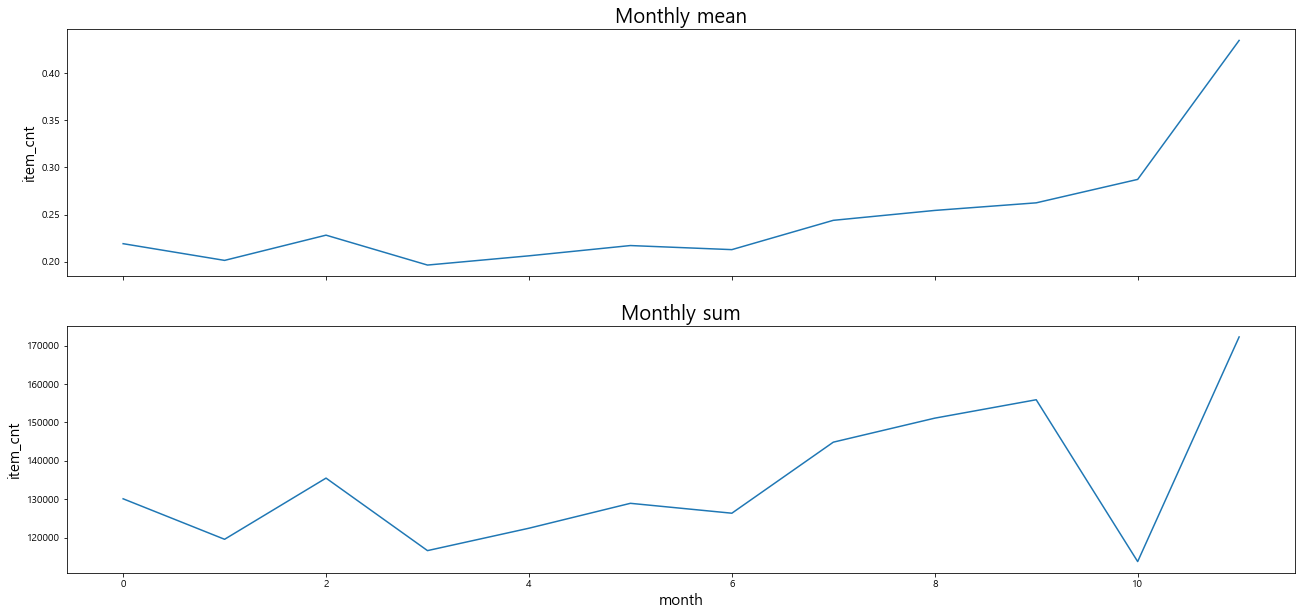

In [81]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

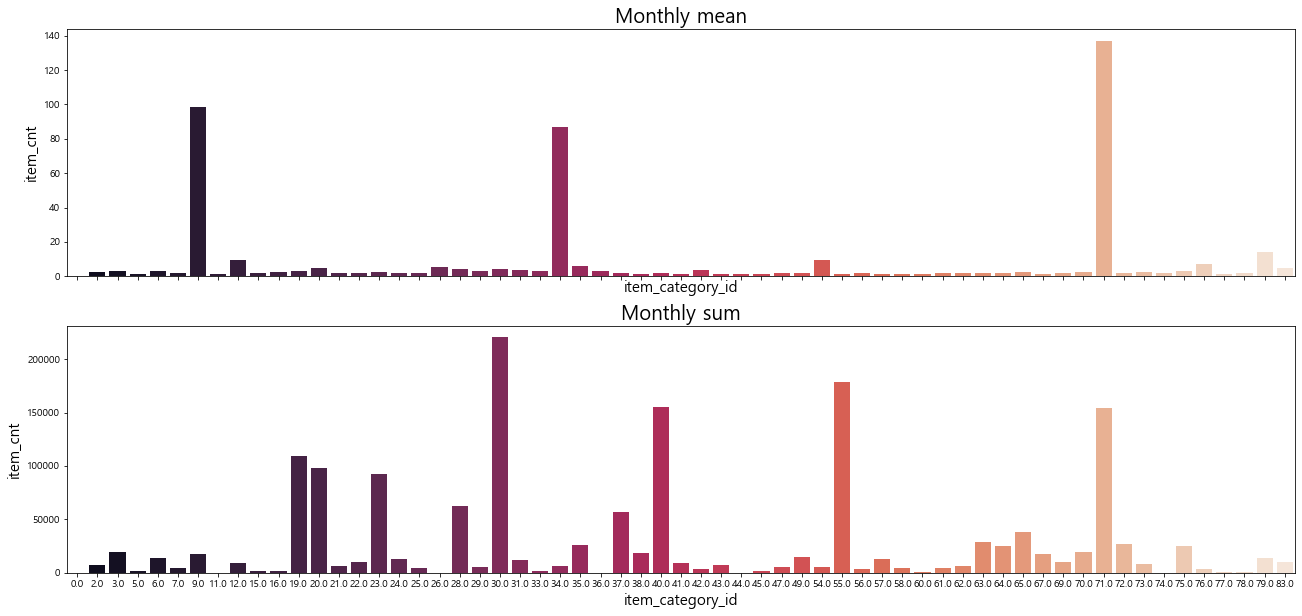

In [82]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

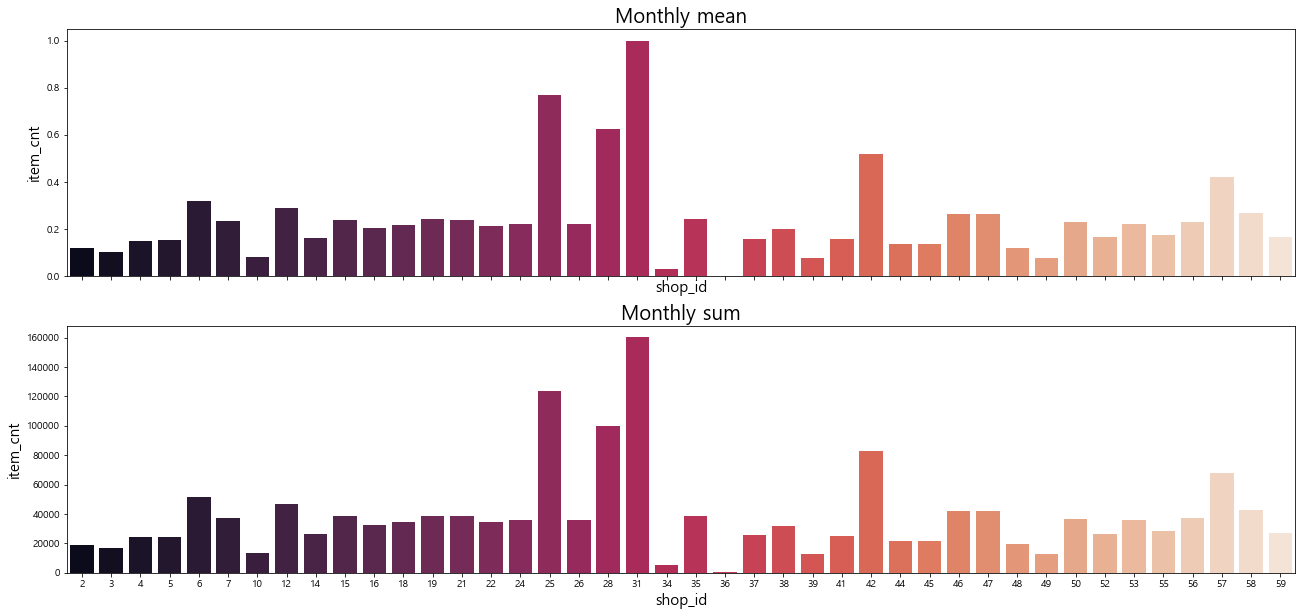

In [83]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

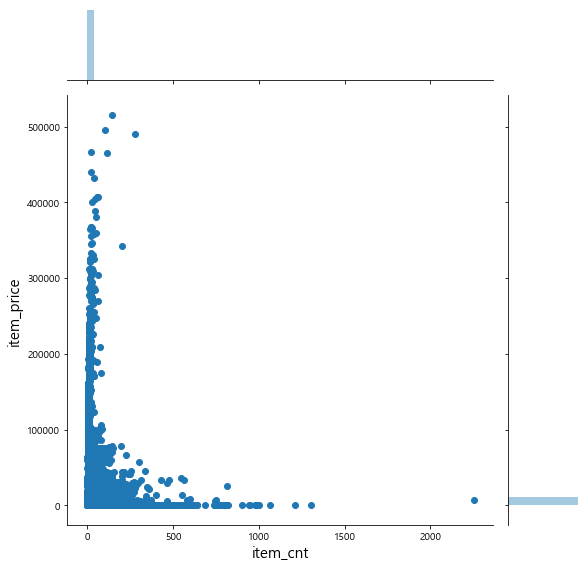

In [84]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

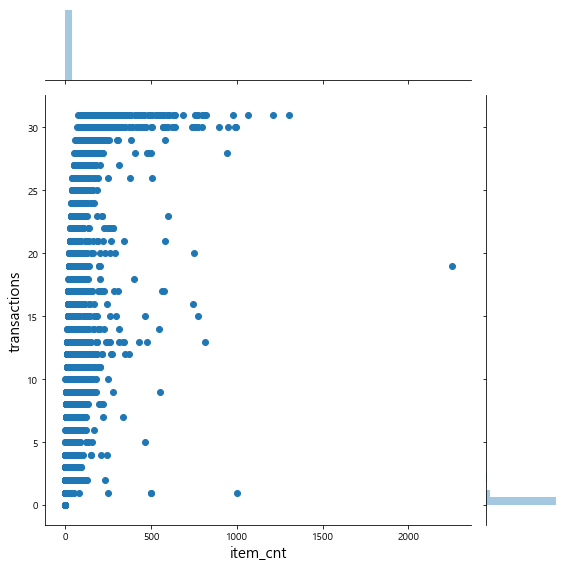

In [85]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

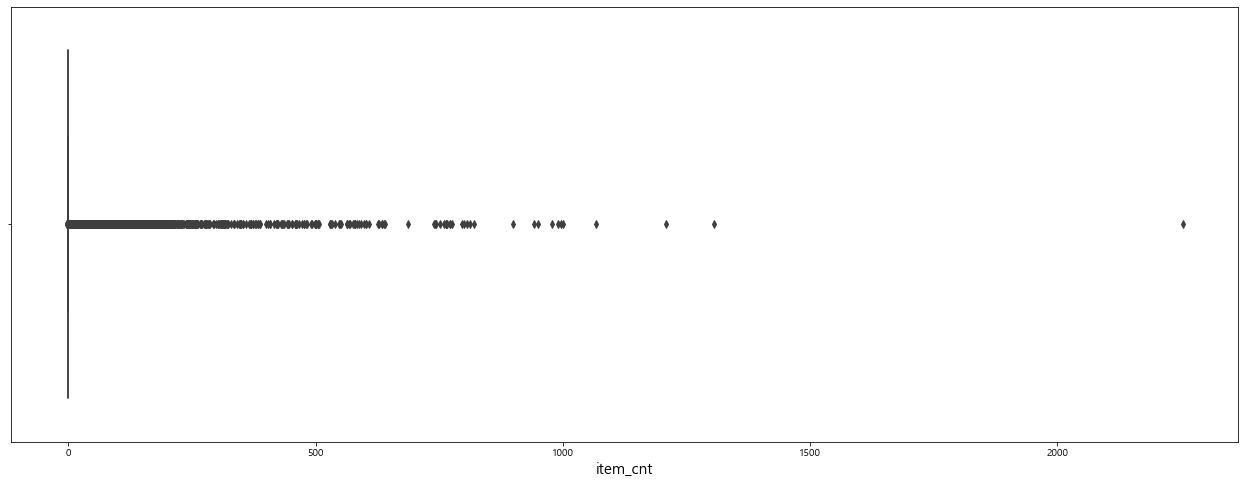

In [86]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

In [87]:
#Removing outliers
#I'll treat "item_cnt" > 20 and < 0, "item_price" >= 400000 as outliers, so I'll remove them.
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

In [88]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

C:\Users\meng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [126]:
train_monthly.sort_values('date_block_num').query('date_block_num>3')[:10]

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
923849,4,50,3851,19.00,8091.00,899.00,10.00,1.11,9.00,2013,...,8091.00,7191.35,7.00,13.00,10.00,3.00,7.00,13.00,3.00,-3.25
923848,4,50,3686,19.00,4495.00,899.00,5.00,1.00,5.00,2013,...,4495.00,6293.00,3.00,13.00,7.00,5.29,3.00,13.00,6.00,-4.25
923847,4,50,3316,19.00,799.00,799.00,1.00,1.00,1.00,2013,...,799.00,4395.00,1.00,3.00,1.67,1.15,3.00,1.00,2.00,-1.25
923843,4,50,7956,6.00,6490.00,6490.00,1.00,1.00,1.00,2013,...,6490.00,28740.00,1.00,2.00,1.33,0.58,2.00,1.00,3.00,-1.25
923845,4,50,1467,19.00,4495.00,899.00,5.00,1.00,5.00,2013,...,4495.00,1499.00,1.00,5.00,2.67,2.08,1.00,2.00,0.00,0.50
923844,4,50,1409,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,5596.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
923850,4,50,4906,19.00,5996.00,1499.00,5.00,1.25,4.00,2013,...,5996.00,12893.00,5.00,7.00,5.67,1.15,7.00,5.00,9.00,-4.00
923846,4,50,3076,19.00,2397.00,799.00,4.00,1.33,3.00,2013,...,2397.00,10162.76,3.00,4.00,3.67,0.58,4.00,3.00,10.00,-3.25
923851,4,50,6727,19.00,998.00,499.00,2.00,1.00,2.00,2013,...,998.00,3496.50,2.00,3.00,2.33,0.58,2.00,3.00,2.00,-1.25
923861,4,50,3328,23.00,11993.90,1998.98,8.00,1.33,6.00,2013,...,11993.90,14243.13,8.00,9.00,8.33,0.58,8.00,9.00,11.00,-5.00


In [90]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

C:\Users\meng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\meng\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [91]:
train_monthly.head(3)

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00,1192.00
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00,2013,0,0.00,inf
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00


In [92]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [93]:
train_monthly.head(3)

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00,1192.00,0.00,18979.50
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00,2013,0,0.00,inf,0.00,35260.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00,0.00,5592.00


In [94]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [95]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').\
    groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [96]:
train_monthly.head(3)

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,1.00,1192.00,0.00,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00,2013,...,0.00,inf,0.00,35260.00,4775.21,30484.79,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,1.00,594.00,0.00,5592.00,1188.30,4403.70,2.00,2.00,2.00,0.00


In [97]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').\
    groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [98]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [99]:
train_monthly.head(10)

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00,2013,...,4775.21,30484.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,1188.30,4403.70,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.50
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,...,5970.00,21980.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,1490.00,24390.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25
5,0,2,7895,6.00,2697.00,899.00,4.00,1.33,3.00,2013,...,2697.00,5750.00,4.00,4.00,4.00,0.00,0.00,0.00,0.00,1.00
6,0,2,7956,6.00,13780.00,6890.00,2.00,1.00,2.00,2013,...,13780.00,21450.00,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.50
7,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,...,1398.50,4197.50,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25
8,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,...,899.00,5095.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25
9,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,...,1399.00,11160.76,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25


In [100]:
train_monthly['item_cnt_shifted1'].unique()

array([ 0.,  9.,  2.,  3.,  1.,  4., 17.,  7.,  6., 10.,  5., 15., 12.,
       18., 11., 13., 20.,  8., 16., 19., 14.])

In [101]:
train_monthly.loc[train_monthly['item_cnt_shifted1']!=0]

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
197996,1,2,5572,2.00,1590.00,1590.00,1.00,1.00,1.00,2013,...,1590.00,17389.50,1.00,9.00,5.00,5.66,9.00,0.00,0.00,-2.00
197998,1,2,5583,5.00,699.00,699.00,1.00,1.00,1.00,2013,...,699.00,4893.00,1.00,2.00,1.50,0.71,2.00,0.00,0.00,-0.25
197999,1,2,7893,6.00,1690.00,1690.00,2.00,2.00,1.00,2013,...,1690.00,26260.00,2.00,3.00,2.50,0.71,3.00,0.00,0.00,-0.25
198000,1,2,7894,6.00,2980.00,1490.00,2.00,1.00,2.00,2013,...,2980.00,22900.00,1.00,2.00,1.50,0.71,1.00,0.00,0.00,0.25
198001,1,2,7895,6.00,799.00,799.00,1.00,1.00,1.00,2013,...,799.00,7648.00,1.00,4.00,2.50,2.12,4.00,0.00,0.00,-0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722943,33,34,3353,24.00,7998.00,3999.00,2.00,1.00,2.00,2015,...,7998.00,35991.00,2.00,2.00,2.00,0.00,2.00,0.00,0.00,0.00
6722944,33,34,4722,24.00,3599.00,3599.00,1.00,1.00,1.00,2015,...,3599.00,14396.00,1.00,2.00,1.50,0.71,2.00,0.00,0.00,-0.25
6722945,33,34,4838,28.00,1399.00,1399.00,1.00,1.00,1.00,2015,...,1399.00,15319.00,1.00,3.00,2.00,1.41,3.00,0.00,0.00,-0.50
6722954,33,34,8547,42.00,1199.00,1199.00,1.00,1.00,1.00,2015,...,1199.00,8393.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00


# Train/validation split
* As we know the test set in on the future, so we should try to simulate the same distribution on our train/validation split.
* Our train set will be the first 3 ~ 28 blocks, validation will be last 5 blocks (29~32) and test will be block 33.
* I'm leaving the first 3 months out because we use a 3 month window to generate features, so these first 3 month won't have really windowed useful features.

In [102]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 4946785
Validation set records: 989412
Test set records: 197879
Train set records: 4946785 (74% of complete data)
Validation set records: 989412 (15% of complete data)


# Mean encoding.
* done after the train/validation split.

In [103]:
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [104]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [105]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

# Build test set
* We want to predict for "date_block_num" 34 so our test set will be block 33 and our predictions should reflect block 34 values. In other words we use block 33 because we want to forecast values for block 34.

In [106]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

# Replacing missing values

In [107]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [108]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [109]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_test[int_features] = X_test[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [110]:
X_test.head().T

,0,1,2,3,4
shop_id,5.00,5.00,5.00,5.00,5.00
item_id,5037.00,5320.00,5233.00,5232.00,5268.00
item_price,749.50,0.00,2997.00,0.00,0.00
mean_item_price,749.50,0.00,999.00,0.00,0.00
item_cnt,1.00,0.00,3.00,0.00,0.00
mean_item_cnt,1.00,0.00,1.00,0.00,0.00
transactions,1.00,0.00,3.00,0.00,0.00
year,2015.00,2015.00,2015.00,2015.00,2015.00
month,9.00,9.00,9.00,9.00,9.00
item_price_unit,749.00,0.00,999.00,0.00,0.00


In [111]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,214200.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,214200.00,11019.40,6252.64,30.00,5381.50,11203.00,16071.50,22167.00
item_price,214200.00,239.96,1852.61,0.00,0.00,0.00,0.00,166944.50
mean_item_price,214200.00,133.81,865.99,0.00,0.00,0.00,0.00,32990.00
item_cnt,214200.00,0.23,0.95,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,214200.00,0.13,0.37,0.00,0.00,0.00,0.00,10.00
transactions,214200.00,0.20,0.73,0.00,0.00,0.00,0.00,15.00
year,214200.00,2015.00,0.00,2015.00,2015.00,2015.00,2015.00,2015.00
month,214200.00,9.00,0.00,9.00,9.00,9.00,9.00,9.00
item_price_unit,214200.00,inf,nan,0.00,0.00,0.00,0.00,inf


# Modeling the data

## Tree based models

## 1. Catboost

In [112]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.354206
0:	learn: 0.8161365	test: 0.8670362	best: 0.8670362 (0)	total: 2s	remaining: 16m 39s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8082952957
bestIteration = 7

Shrink model to first 8 iterations.


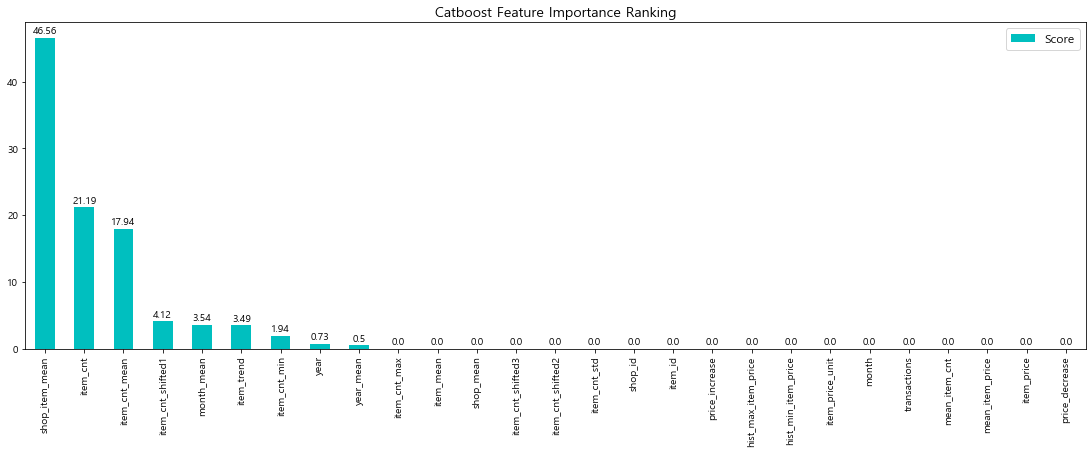

In [113]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [129]:
feature_score

,Feature,Score
24,shop_item_mean,46.56
4,item_cnt,21.19
16,item_cnt_mean,17.94
18,item_cnt_shifted1,4.12
26,month_mean,3.54
21,item_trend,3.49
14,item_cnt_min,1.94
7,year,0.73
25,year_mean,0.50
15,item_cnt_max,0.00


In [114]:
X_test.head()

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,5,5037,749.50,749.50,1.00,1.00,1.00,2015,9,749.00,...,1.15,3.00,1.00,1.00,-1.00,0.13,0.70,0.28,0.22,0.17
1,5,5320,0.00,0.00,0.00,0.00,0.00,2015,9,0.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.05,0.00,0.22,0.17
2,5,5233,2997.00,999.00,3.00,1.00,3.00,2015,9,999.00,...,1.00,1.00,2.00,3.00,-0.75,0.13,0.07,0.12,0.22,0.17
3,5,5232,0.00,0.00,0.00,0.00,0.00,2015,9,0.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00,0.22,0.17
4,5,5268,0.00,0.00,0.00,0.00,0.00,2015,9,0.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.05,0.00,0.22,0.17


In [115]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [116]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

Train rmse: 0.6777032905043281
Validation rmse: 0.8082952956725398


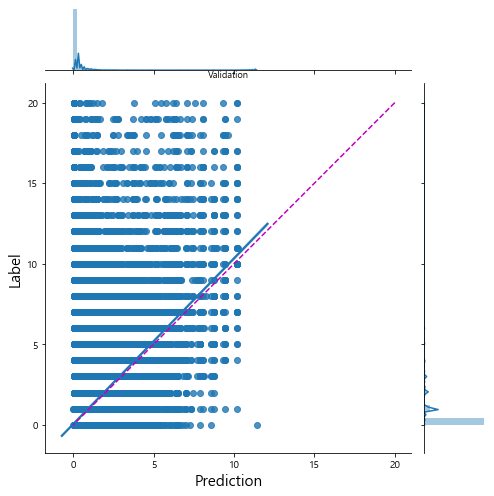

In [117]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
# model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_validation, 'Validation')

## 2. XGB

In [118]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[09:52:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.84423	validation_1-rmse:0.88166
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.67759	validation_1-rmse:0.81824
Stopping. Best iteration:
[4]	validation_0-rmse:0.69545	validation_1-rmse:0.79816



XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)

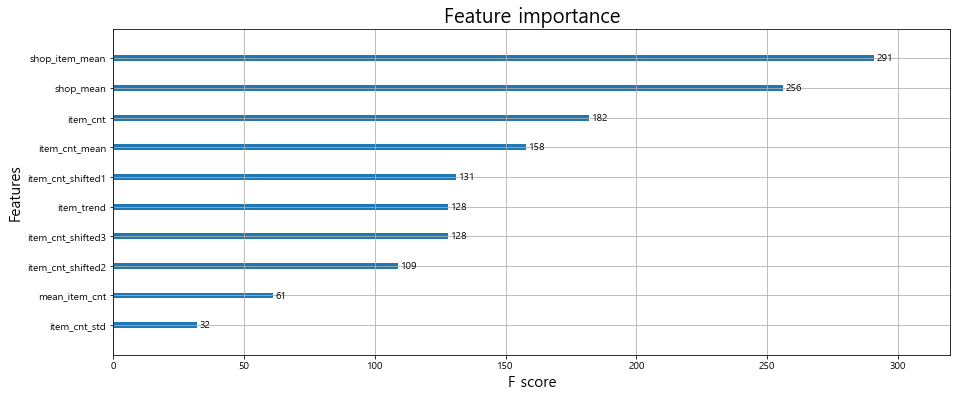

In [119]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [120]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [121]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.697475453300762
Validation rmse: 0.798117433161014


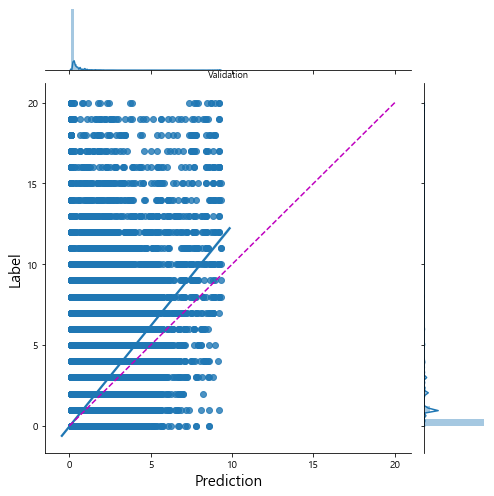

In [122]:
# model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')
model_performance_sc_plot(xgb_val_pred, Y_validation, 'Validation')